# Load data

<https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data>

In [1]:
import re

import gender_guesser.detector as detector
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import sage

In [2]:
# Load data
df = sage.datasets.airbnb()

# Sample rows
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
# Categorical features
categorical_columns = ["neighbourhood_group", "neighbourhood", "room_type"]
for column in categorical_columns:
    df[column] = pd.Categorical(df[column]).codes

In [4]:
# Exclude outliers (top 0.5%)
df = df[df["price"] < df["price"].quantile(0.995)]

In [5]:
# Features derived from name
df["name_length"] = df["name"].apply(lambda x: len(x))
df["name_isupper"] = df["name"].apply(lambda x: int(x.isupper()))
df["name_words"] = df["name"].apply(lambda x: len(re.findall(r"\w+", x)))

In [6]:
# Host gender guess
guesser = detector.Detector()
df["host_gender"] = df["host_name"].apply(lambda x: guesser.get_gender(x.split(" ")[0]))
df["host_gender"] = pd.Categorical(df["host_gender"]).codes

In [7]:
# Number of days since last review
most_recent = df["last_review"].max()
df["last_review"] = (most_recent - df["last_review"]).dt.days
df["last_review"] = (df["last_review"] - df["last_review"].mean()) / df[
    "last_review"
].std()
df["last_review"] = df["last_review"].fillna(-5)

In [8]:
# Missing values
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

In [9]:
# Normalize other numerical features
df["number_of_reviews"] = (
    df["number_of_reviews"] - df["number_of_reviews"].mean()
) / df["number_of_reviews"].std()
df["availability_365"] = (df["availability_365"] - df["availability_365"].mean()) / df[
    "availability_365"
].std()
df["name_length"] = (df["name_length"] - df["name_length"].mean()) / df[
    "name_length"
].std()

In [10]:
# Normalize latitude and longitude
df["latitude"] = (df["latitude"] - df["latitude"].mean()) / df["latitude"].std()
df["longitude"] = (df["longitude"] - df["longitude"].mean()) / df["longitude"].std()

In [11]:
# Drop columns
df = df.drop(["id", "host_id", "host_name", "name"], axis=1)

In [12]:
# New sample rows
df.head(5)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,name_length,name_isupper,name_words,host_gender
0,1,108,-1.492033,-0.440795,1,149,1,-0.321948,-0.034852,0.21,6,1.922931,-0.276169,0,7,2
1,2,127,0.452497,-0.687792,0,225,1,0.484307,-0.552366,0.38,2,1.846815,-1.513431,0,3,1
2,2,94,1.467544,0.219381,1,150,3,-0.523512,-5.000000,0.00,1,1.922931,-0.180995,1,6,1
3,1,41,-0.802204,-0.167581,0,89,1,5.523401,-0.661188,4.64,1,0.621350,-0.561691,0,5,5
4,2,61,1.274978,0.174098,0,80,10,-0.321948,-0.109819,0.10,1,-0.855298,1.056268,0,8,1


In [13]:
# Rearrange columns
target_col = "price"
cols = df.columns.tolist()
del cols[cols.index(target_col)]
cols.append(target_col)
feature_names = cols[:-1]
df = df[cols]

# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0
)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0
)
Y_train = train[:, -1:].copy()
Y_val = val[:, -1:].copy()
Y_test = test[:, -1:].copy()
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [14]:
train.shape

(38879, 15)

In [15]:
test.shape

(4859, 15)

# Train model

In [16]:
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [17]:
# Create model
device = torch.device("cuda")
model = nn.Sequential(
    nn.Linear(len(feature_names), 512),
    nn.ELU(),
    nn.Linear(512, 512),
    nn.ELU(),
    nn.Linear(512, 1),
).to(device)

# Training parameters
lr = 1e-3
mbsize = 512
max_nepochs = 250
loss_fn = nn.MSELoss()
lookback = 20
verbose = False

# Data loaders
train_set = TensorDataset(
    torch.tensor(train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32)
)
train_loader = DataLoader(train_set, batch_size=mbsize, shuffle=True)
val_x = torch.tensor(val, dtype=torch.float32, device=device)
val_y = torch.tensor(Y_val, dtype=torch.float32, device=device)
test_x = torch.tensor(test, dtype=torch.float32, device=device)
test_y = torch.tensor(Y_test, dtype=torch.float32, device=device)

# Setup
optimizer = optim.Adam(model.parameters(), lr=lr)
min_criterion = np.inf
min_epoch = 0

# Train
for epoch in range(max_nepochs):
    for x, y in train_loader:
        # Move to device
        x = x.to(device=device)
        y = y.to(device=device)

        # Take gradient step
        loss = loss_fn(model(x), y)
        loss.backward()
        optimizer.step()
        model.zero_grad()

    # Check progress.
    with torch.no_grad():
        # Calculate validation loss.
        val_loss = loss_fn(model(val_x), val_y).item()
        if verbose:
            print("{}Epoch = {}{}".format("-" * 10, epoch + 1, "-" * 10))
            print("Val loss = {:.4f}".format(val_loss))

        # Check convergence criterion.
        if val_loss < min_criterion:
            min_criterion = val_loss
            min_epoch = epoch
            best_model = deepcopy(model)
        elif (epoch - min_epoch) == lookback:
            if verbose:
                print("Stopping early")
            break

# Keep best model
model = best_model

In [18]:
# Calculate performance
mean = torch.mean(train_set.tensors[1], dim=0, keepdim=True).to(device)
base_mse = nn.MSELoss()(mean.repeat(len(test_y), 1), test_y)
mse = nn.MSELoss()(model(test_x), test_y)

print("Base rate MSE = {:.2f}".format(base_mse))
print("Model MSE = {:.2f}".format(mse))

Base rate MSE = 12293.56
Model MSE = 6690.47


# Global Method

## SIM-Shapley

In [22]:
from sim_shapley import imputers, estimator
from sklearn.metrics import mean_squared_error

In [82]:
sim_imputer = imputers.MarginalImputer(model, train[:512], sample_num=10)
sim_estimator = estimator.SIM_Shapley(train[:512], sim_imputer, mean_squared_error, l2_penalty=0.01, t=0.55)
sim_value = sim_estimator(test, Y_test, 150, 512,thresh=0.025, random_state=114514, n_jobs=1) # Notice: nn model cannot parallel by cpu

Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


  0%|          | 0/1 [00:00<?, ?it/s]

Convergence detected! Gap is 0.024925105960232164.


<BarContainer object of 15 artists>

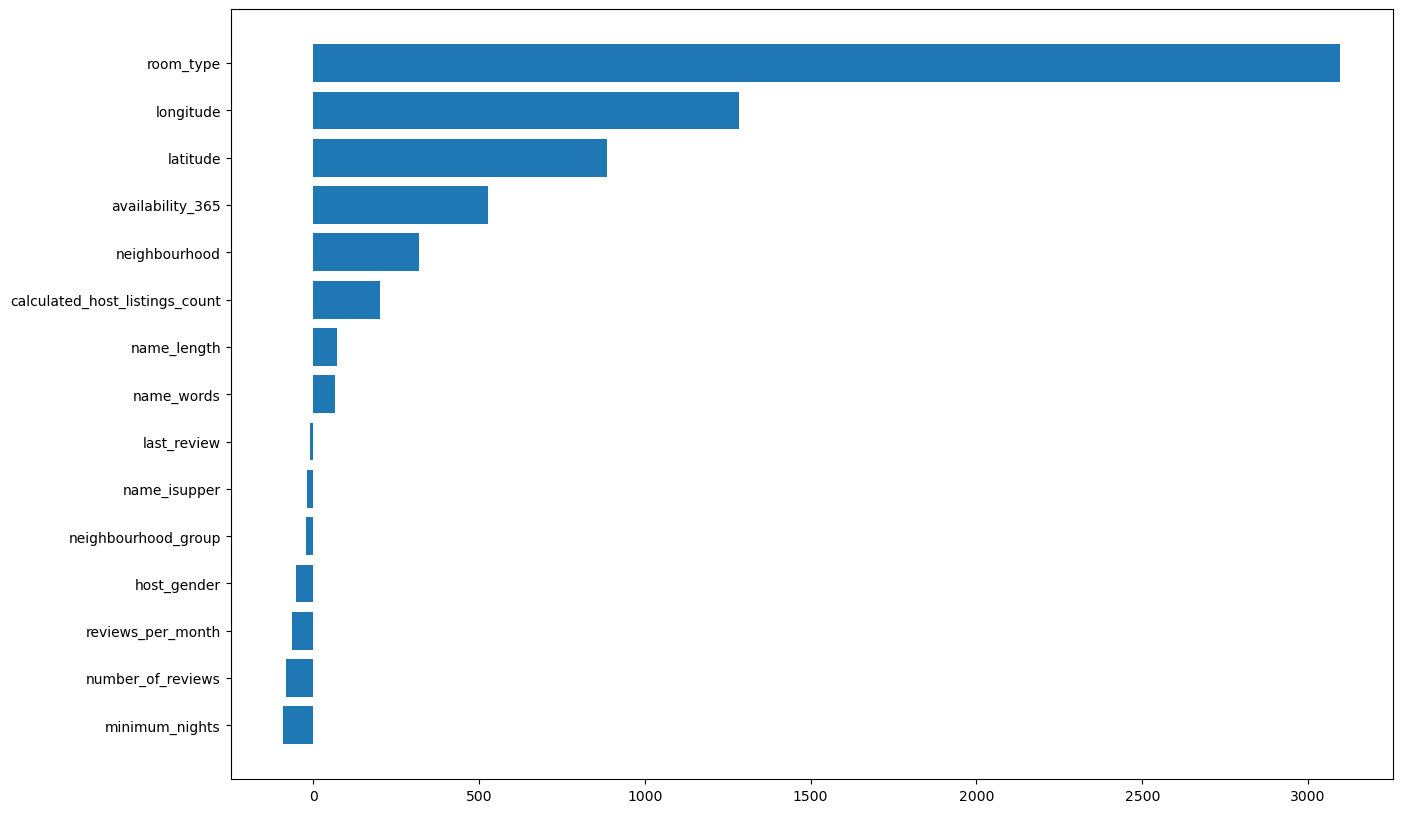

In [83]:
a = dict(zip(feature_names, sim_value))
sorted(a.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
m = sorted(a.items(), key=lambda kv: (kv[1], kv[0]))
plt.figure(figsize=(15, 10))
plt.barh([k[0] for k in m], [k[1] for k in m])

## SAGE

In [76]:
imputer = sage.MarginalImputer(model, train[:512])
sage_estimator = sage.PermutationEstimator(imputer, "mse")
sage_values = sage_estimator(test, Y_test, thresh=0.025)

Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


  0%|          | 0/1 [00:00<?, ?it/s]

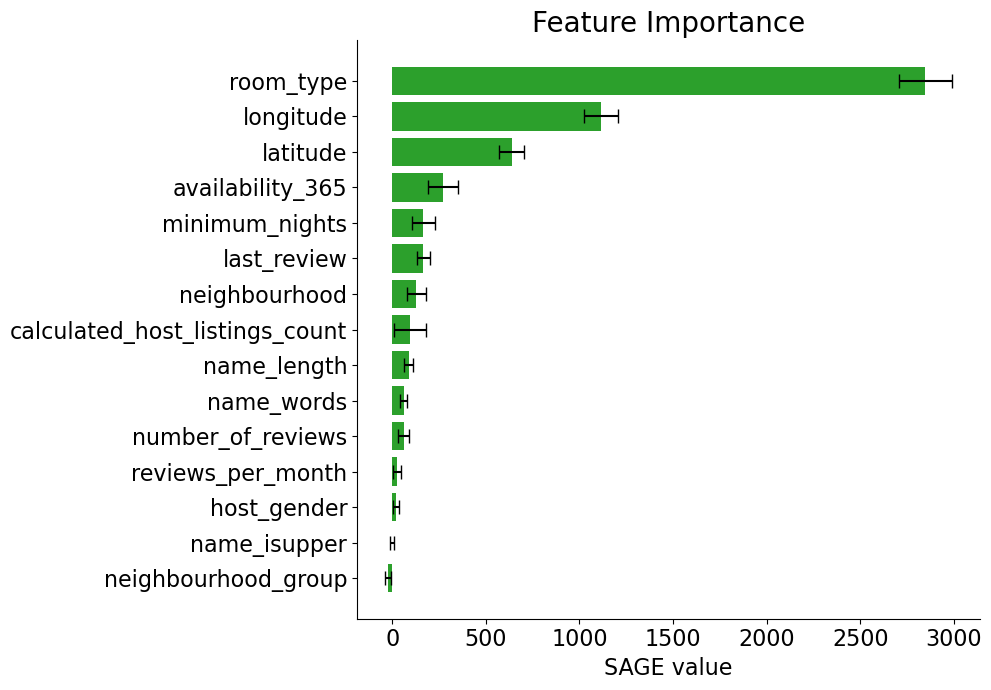

In [77]:
sage_values.plot(feature_names)

## Comparison

In [84]:
import scipy.stats as st
from scipy.stats import wasserstein_distance

In [85]:
# Pearson Correlation
st.pearsonr(sage_values.values, sim_value)[0]

0.9860938393079786

In [87]:
# wasserstein_distance
wasserstein_distance(sim_value, sage_values.values)

117.20785015081735

# Local Method

## SIM-Shapley

In [48]:
from sim_shapley import imputers, estimator
from sklearn.metrics import mean_squared_error

In [57]:
sim_imputer = imputers.MarginalImputer(model, train[:512], sample_num=100)
sim_estimator = estimator.SIM_Shapley(train[:512], sim_imputer, mean_squared_error, l2_penalty=0.01, t=0.5, method_type='local')
sim_value = sim_estimator(test[10], Y_test[10], 225, 512, n_jobs=1)

Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


  0%|          | 0/1 [00:00<?, ?it/s]

Convergence detected! Gap is 0.04678802888827228.


<BarContainer object of 15 artists>

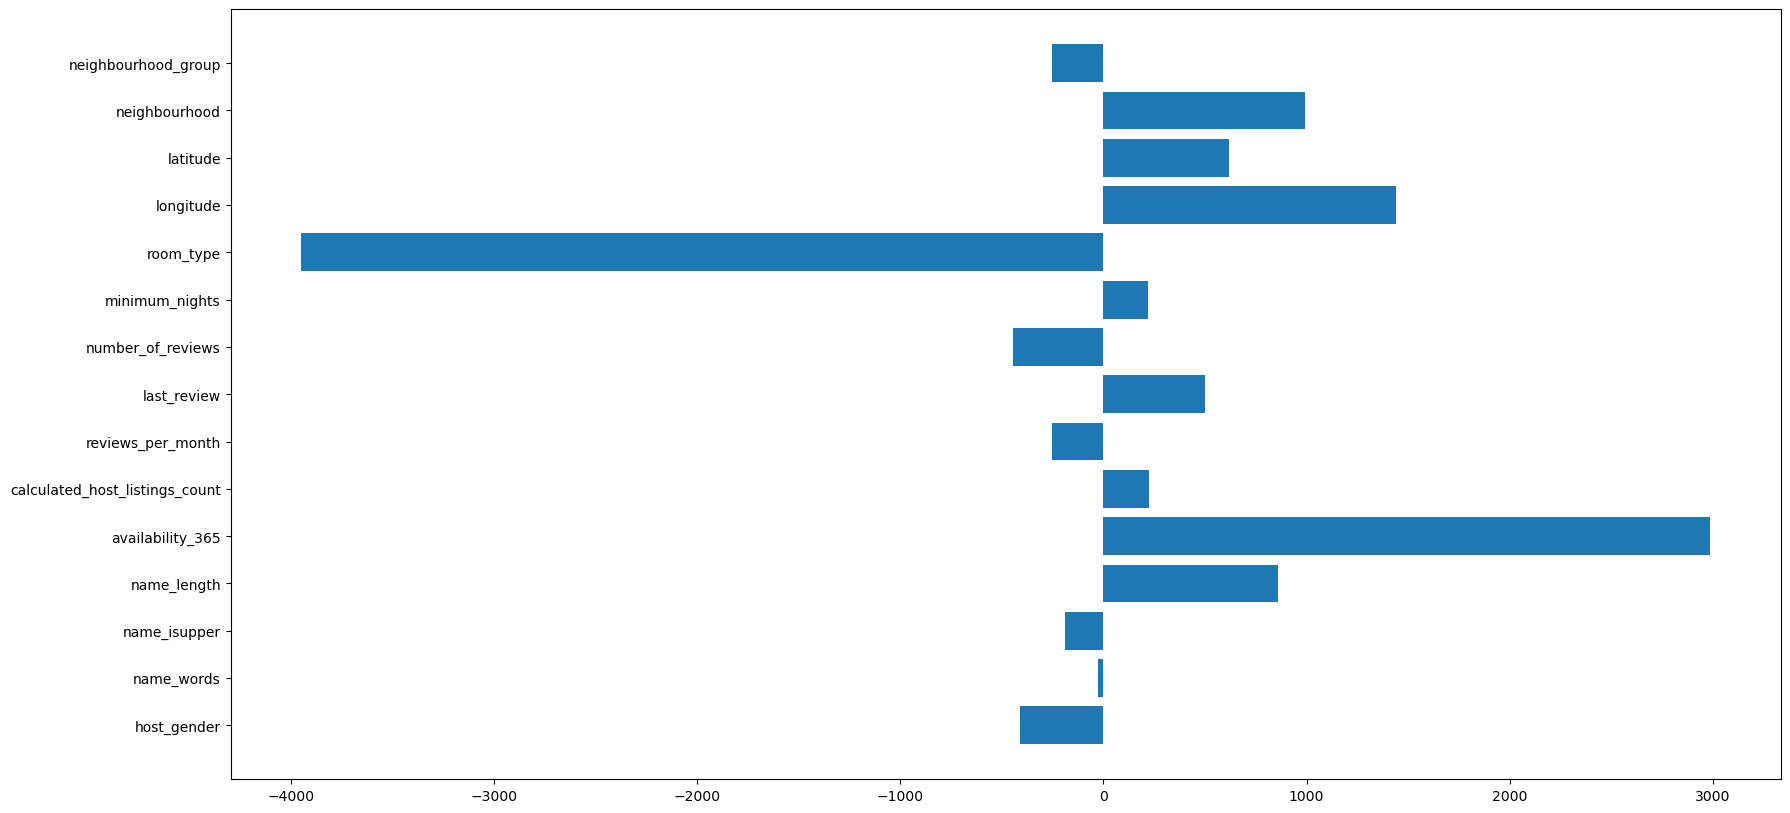

In [58]:
plt.figure(figsize=(20, 10))
plt.barh(feature_names[::-1], sim_value[::-1])

## KernelSHAP

In [51]:
from shapreg.utils import mseloss
from shapreg import removal, games, shapley

# Make model callable
model_lam = lambda x: model(torch.tensor(x, dtype=torch.float32, device=device)).cpu().data.numpy()

# Model extension
marginal_extension = removal.MarginalExtension(train[:512], model_lam)
# Set up game

game = games.PredictionLossGame(marginal_extension, test[10], Y_test[10], mseloss)
explanation = shapley.ShapleyRegression(game, paired_sampling=False)
explanation.values

  0%|          | 0/1 [00:00<?, ?it/s]

array([  -19.30496198,  1280.18531335,   503.01389089,  1712.31289507,
       -4361.42512571,  -183.54046789,  -179.57061136,   145.5409469 ,
        -505.19125352,   473.45466292,  2694.1375857 ,   672.92051705,
          32.61418479,   148.27806726,  -138.19306392])

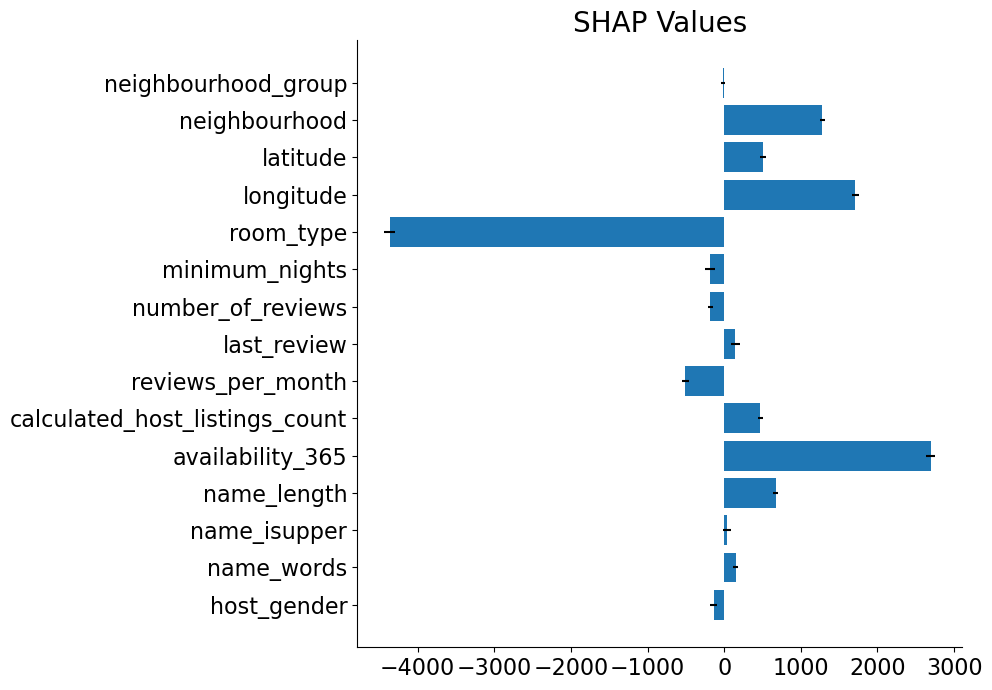

In [52]:
explanation.plot(feature_names, title='SHAP Values', sort_features=False)

## Comparison

In [59]:
import scipy.stats as st
from scipy.stats import wasserstein_distance

In [60]:
# Pearson Correlation
st.pearsonr(explanation.values, sim_value)[0]

0.9820177385172686

In [62]:
# wasserstein_distance
wasserstein_distance(sim_value, explanation.values)

163.1468263491904